In [1]:
import math
import statistics
import numpy as np
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier



%matplotlib inline
from fancyimpute import IterativeImputer, KNN
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, label_binarize, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import metrics

#from yellowbrick.model_selection import FeatureImportances

In [3]:
df = pd.read_csv('cleaned_df.csv', low_memory = False)
df.drop(['Unnamed: 0'], axis = 1, inplace=True)

## KNN Baseline

This model looks at data points that are close to the point in question. Points that are close together are expected to be similar to each other.

Generate a simple baseline model with select features that are expected to have an impact in determining the target (based on literature).

Target was engineered. Based on the paper that accompanied the dataset, the NRCS tolerable soil erosion is 5 tons/acre. Therefore, if soil erosion values are less than 5, soil erosion is "tolerated". If the value is greater than 5, soil erosion is "not tolerated.

1st model features: slope, scifo, sciom, removal, tillage, rotation

target: soil erosion

0.8931685626840676
[[13368  2907]
 [ 2643 33033]]


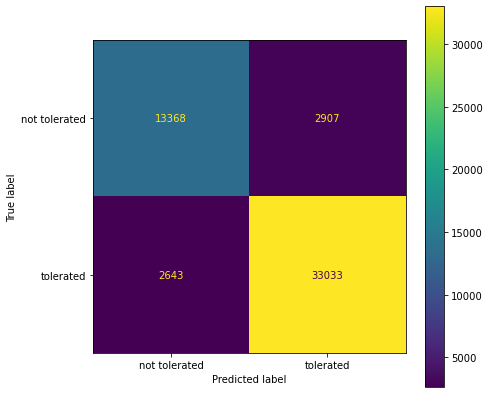

In [6]:
base_X_y = df[['soil_erosion','Slope','scifo','sciom','removal','tillage','rotation']]
base_X_y = base_X_y.dropna()

y = base_X_y['soil_erosion']
X = base_X_y[['Slope','scifo','sciom','removal','tillage','rotation']]

le = LabelEncoder()
X = X.copy()
X.loc[:,'removal'] = le.fit_transform(X['removal'])
X.loc[:,'rotation'] = le.fit_transform(X['rotation'])
X.loc[:,'tillage'] = le.fit_transform(X['tillage'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

def func(y):
    if y <= 5: #Values for erosion that are above the NRCS tolerable soil loss limit of 1.12 kg m-2 (5 tons acre-1 ). 58(2):
        return 'tolerated'
    else:
        return 'not tolerated'
y_train = y_train.apply(func)
y_test = y_test.apply(func)

s = StandardScaler()
s.fit(X_train)
X_train_scaled=s.transform(X_train)
X_test_scaled= s.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_scaled, y_train) 
y_predict = knn.predict(X_test_scaled)
print(metrics.accuracy_score(y_test, y_predict))
print(metrics.confusion_matrix(y_test, y_predict))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn, X_test_scaled, y_test, ax=ax);

### Cross validation

Cross validation on the 1st model

[0.82279797 0.83530952 0.82879692 0.82383061 0.81085659 0.84743022
 0.86040423 0.86575553 0.86868142 0.87291627]
[0.8216953428247826, 0.8151351794934424, 0.8369984555225777, 0.8347847916474616, 0.8436779283638736, 0.8424921621587174, 0.8475893707169689, 0.8464074499211977, 0.8504036000655674, 0.8492563460518674, 0.8523362219601243, 0.8517818466027572, 0.853860790429783, 0.8537067861264104, 0.856205339169969, 0.8554392170102675, 0.8573987809284531, 0.8568713612298671, 0.8580917617595037]


Text(0, 0.5, 'Cross-Validated Accuracy')

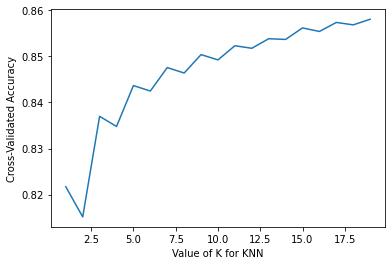

In [7]:
base_X_y = df[['soil_erosion','Slope','scifo','sciom','removal','tillage','rotation']]
base_X_y = base_X_y.dropna()

y = base_X_y['soil_erosion']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X = base_X_y[['Slope','scifo','sciom','removal','tillage','rotation']]
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
le = LabelEncoder()
X = X.copy()
X.loc[:,'removal'] = le.fit_transform(X['removal'])
X.loc[:,'rotation'] = le.fit_transform(X['rotation'])
X.loc[:,'tillage'] = le.fit_transform(X['tillage'])
def func(y):
    if y <= 5: #Values for erosion that are above the NRCS tolerable soil loss limit of 1.12 kg m-2 (5 tons acre-1 ). 58(2):
        return 'tolerated'
    else:
        return 'not tolerated'
y = y.apply(func)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

k_range = list(range(1, 20))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

There doesn't seem to be a big increase in accuracy when the value for K in KNN is increased. 

### GridSearchCV 
To find the best parameters

The following block of code was ran in another notebook. The code took a couple hours to run so the result was pasted in markdown

In [8]:
# y = base_X_y['soil_erosion']

# y= y.apply(func)
# k_range = list(range(1, 50))
# param_grid = dict(n_neighbors=k_range)
# grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
# grid.fit(X, y);
# print(grid.cv_results_)

# def get_best_model(model_grid):
#     best_k = model_grid.cv_results_['rank_test_score'][0]
#     print (best_k, model_grid.cv_results_['mean_test_score'][best_k], model_grid.cv_results_['std_test_score'][best_k])

# print(get_best_model(grid))

In [9]:
print('The result for the above model is 48 0.8650407169363117 0.023009326270680867')

The result for the above model is 48 0.8650407169363117 0.023009326270680867


### Add more features to improve the model
2nd model features: slope, scifo, sciom, removal, tillage, rotation, soil texture, and yield
Target: soil erosion

0.9315493391900743
[[14444  1783]
 [ 1770 33909]]


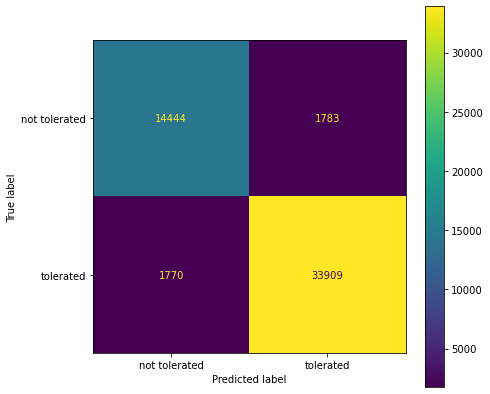

In [11]:
X_y2 = df[['soil_erosion','Slope','scifo','sciom','removal','tillage','rotation', 'soil_text','yield1']]
X_y2 = X_y2.dropna()

y2 = X_y2['soil_erosion']
X2 = X_y2[['Slope','scifo','sciom','removal','tillage','rotation', 'soil_text','yield1']]

le = LabelEncoder()
X2 = X2.copy()
X2.loc[:,'removal'] = le.fit_transform(X2['removal'])
X2.loc[:,'rotation'] = le.fit_transform(X2['rotation'])
X2.loc[:,'tillage'] = le.fit_transform(X2['tillage'])
X2.loc[:,'soil_text'] = le.fit_transform(X2['soil_text'])

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state = 42)

def func(y):
    if y <= 5: #Values for erosion that are above the NRCS tolerable soil loss limit of 1.12 kg m-2 (5 tons acre-1 ). 58(2):
        return 'tolerated'
    else:
        return 'not tolerated'
y_train = y_train.apply(func)
y_test = y_test.apply(func)

s = StandardScaler()
s.fit(X_train)
X_train_scaled=s.transform(X_train)
X_test_scaled= s.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_scaled, y_train) 
y_predict = knn.predict(X_test_scaled)
print(metrics.accuracy_score(y_test, y_predict))
print(metrics.confusion_matrix(y_test, y_predict))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn, X_test_scaled, y_test, ax=ax);

# Logistic Regression

Logistic regression fits the data into a linear regression model and then transform the output into a logistic sigmoid function in order to return a value between 0 and 1 (no or yes). Gives two possible outcomes.

In [18]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_predict = lr.predict(X_test_scaled)
print("The accuracy score on the test set is {}.".format(metrics.accuracy_score(y_test, y_predict)))
print("The confusion matrix \n {}".format(metrics.confusion_matrix(y_test, y_predict)))

lr_acc = cross_val_score(lr, X_train_scaled, y_train).mean()
lr_std = cross_val_score(lr, X_train_scaled,y_train).std()
print('Accuracy of training data using logistic regression: {} +/- {}'.format(round(lr_acc,2), round(lr_std,2)))

print(lr.predict_proba(X_test_scaled))
print(lr.coef_)
print(X_train.columns)


The accuracy score on the test set is 0.7952067198397103.
The confusion matrix 
 [[ 9883  6344]
 [ 4286 31393]]
Accuracy of training data using logistic regression: 0.79 +/- 0.0
[[0.13895627 0.86104373]
 [0.06192587 0.93807413]
 [0.99293385 0.00706615]
 ...
 [0.1857228  0.8142772 ]
 [0.26607337 0.73392663]
 [0.14337077 0.85662923]]
[[-0.79306616 -0.01960457  2.67258813 -0.2602302  -1.04499587 -0.14037866
   0.07953312 -0.74949197]]
Index(['Slope', 'scifo', 'sciom', 'removal', 'tillage', 'rotation',
       'soil_text', 'yield1'],
      dtype='object')


For the logistic regression model, the most impactful features are 1) amount of organic matter, 2) tillage, 3) slope, 4) yield were the most important features.

The logistic regression model had a lower accuracy than KNN but it provides some inside on what the important features are.

## Naive Bayes
Naive Bayes relies on the Bayes Theorem for calculating probabilities. It assumes that features are independent and is not affected by other features. It uses the probability of the features to predict the probility of the targe classes.

In [22]:
y = df['soil_erosion']

In [23]:
#Make "tolerated" and "not tolerated" 1s and 0s for naive bayes model.
def func(y):
    if y <= 5: #Values for erosion that are above the NRCS tolerable soil loss limit of 1.12 kg m-2 (5 tons acre-1 ). 58(2):
        return 'tolerated'
    else:
        return 'not tolerated'
y = y.apply(func)
y = (y != 'tolerated').astype(int)

In [20]:
y.value_counts()

tolerated        178772
not tolerated     80980
Name: soil_erosion, dtype: int64

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


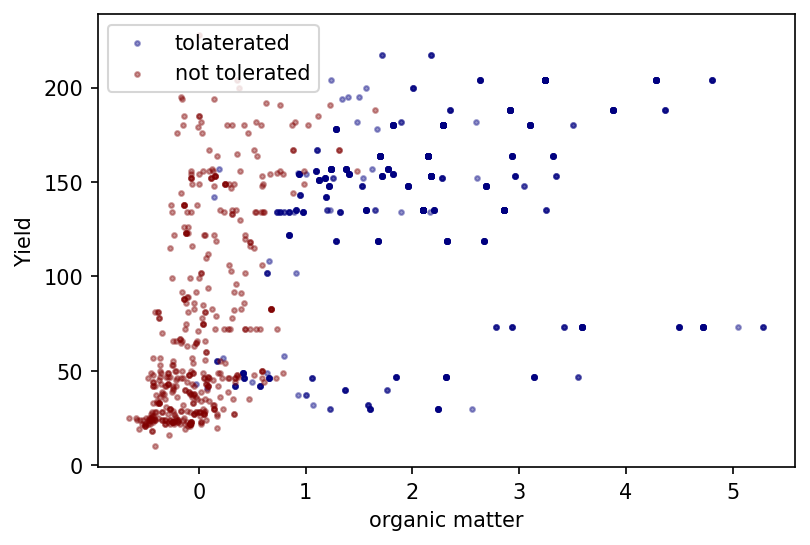

In [21]:
def scatter_plot_data(data):
    plt.figure(dpi=150)
    for ix, label in enumerate(['tolaterated','not tolerated']):
        new_data = df[df['soil_erosion']==ix]
        plt.scatter(new_data['sciom'], new_data['yield1'],c=plt.cm.jet(ix/0.5), alpha=0.4, label=label, s=5)
    plt.ylabel("Yield")
    plt.xlabel("organic matter")
    plt.legend(loc="upper left");

scatter_plot_data(df)

This is an interesting visualization to see that tolearted soil erosion levels generally have higher organic matter in the field. On hte other hand, there is a cluster of points where soil erosion is not tolerated. In these areas, there is low organic matter and yield. 

In [24]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
nb.score(X_test_scaled, y_test)

0.7498169768427542

In [25]:
prediction = nb.predict(X_test_scaled)
print(confusion_matrix(y_test, prediction))

[[10455  5772]
 [ 7214 28465]]


In [26]:
nb = BernoulliNB()
nb.fit(X_train_scaled,y_train)
nb.score(X_test_scaled,y_test)

0.7466381535853274

In [27]:
prediction = nb.predict(X_test_scaled)
print(confusion_matrix(y_test, prediction))

[[ 9834  6393]
 [ 6758 28921]]


The Naive Bayes model did not perform as well as KNN. 

# Linear SVC
Hard thresholds where misclassifications are not allowed has low bias to training data and high variance to test data. Soft margin classifer to set a threshold that allows misclassifications, so cross-validation is used to allow some samples to be misclassfied so that other observations can be correctly classified.

In [26]:
# linearsvc = LinearSVC(max_iter=50000)
# linearsvc.fit(X_train, y_train)
# linearsvc.score(X_test,y_test)

This model takes a while to run, it will also crash the notebook. The test score is 0.7946480175702231.

In [27]:
# score = linearsvc.score(X_train, y_train)
# print("Score: ", score)

# cv_scores = cross_val_score(linearsvc, X_train, y_train, cv=10)
# print("CV average score: {}".format(cv_scores.mean()))

# y_pred = linearsvc.predict(X_test)

# cm = confusion_matrix(y_test, y_pred)
# print(cm)

# cr = classification_report(y_test, y_pred)
# print(cr) 

Not able to print out the reports, the test score was lower than other models, so skip this model for now.

# Decision Tree
A decision tree can be used to represent decisions and decision making, where each condition(node) are split into branches. A branch that cannot be split further is a leaf. This splitting maps the possible outcomes of each choice (feature's different values are split).

0.9810376549691265
0.9454013023542558
[[14860  1367]
 [ 1467 34212]]
Score:  0.9810376549691265
CV average score: 0.9446831193178395
               precision    recall  f1-score   support

not tolerated       0.91      0.92      0.91     16227
    tolerated       0.96      0.96      0.96     35679

     accuracy                           0.95     51906
    macro avg       0.94      0.94      0.94     51906
 weighted avg       0.95      0.95      0.95     51906



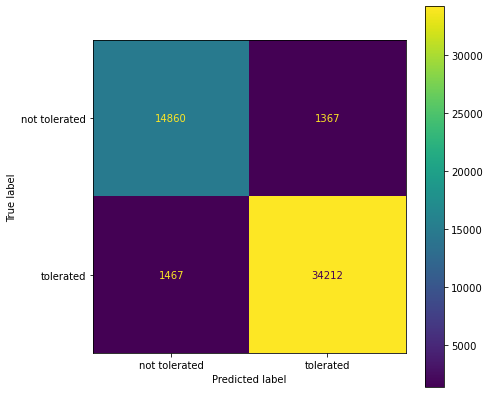

In [28]:
decisiontree = DecisionTreeClassifier(max_depth=27)
decisiontree.fit(X_train_scaled, y_train)
print(decisiontree.score(X_train_scaled,y_train))
print(decisiontree.score(X_test_scaled,y_test))
y_pred = decisiontree.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(decisiontree, X_test_scaled, y_test, ax=ax);

score = decisiontree.score(X_train_scaled, y_train)
print("Score: ", score)

cv_scores = cross_val_score(decisiontree, X_train_scaled, y_train, cv=10)
print("CV average score: {}".format(cv_scores.mean()))

print(classification_report(y_test, y_pred))

# Random Forest

A random forest combines the output of multiple decision tree. An ensemble method.

0.9810617371954803
0.952741494239587
[[14890  1337]
 [ 1116 34563]]
Score:  0.9810617371954803
CV average score: 0.9522015857951434
               precision    recall  f1-score   support

not tolerated       0.93      0.92      0.92     16227
    tolerated       0.96      0.97      0.97     35679

     accuracy                           0.95     51906
    macro avg       0.95      0.94      0.94     51906
 weighted avg       0.95      0.95      0.95     51906



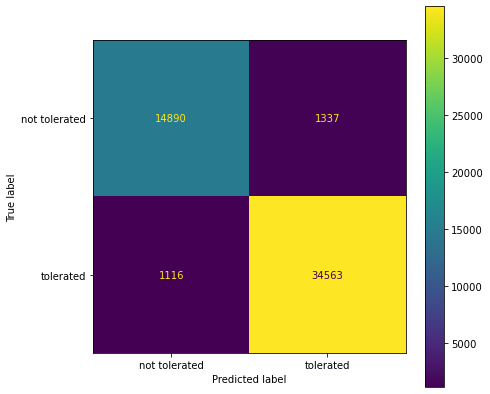

In [29]:
randomforest = RandomForestClassifier(n_estimators=100)
randomforest.fit(X_train_scaled, y_train)
print(randomforest.score(X_train_scaled,y_train))
print(randomforest.score(X_test_scaled,y_test))
y_pred = randomforest.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(randomforest, X_test_scaled, y_test, ax=ax);

score = randomforest.score(X_train_scaled, y_train)
print("Score: ", score)

cv_scores = cross_val_score(randomforest, X_train_scaled, y_train, cv=10)
print("CV average score: {}".format(cv_scores.mean()))

print(classification_report(y_test, y_pred))

# KNN

0.9315493391900743
[[14444  1783]
 [ 1770 33909]]


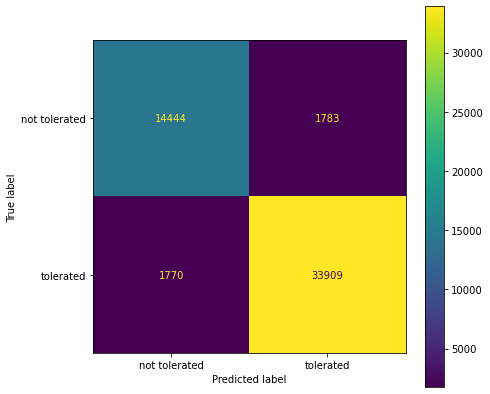

In [30]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_scaled, y_train) 
y_predict = knn.predict(X_test_scaled)
print(metrics.accuracy_score(y_test, y_predict))
print(metrics.confusion_matrix(y_test, y_predict))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn, X_test_scaled, y_test, ax=ax);

# XGBoost
Extreme Gradient Boosting. Uses a decision-tree based ensemble machine learning algorithm



In [59]:
select_df = df[['soil_erosion','Slope','scifo','sciom','removal','tillage','rotation', 'soil_text','yield1']]
select_df = select_df.dropna()

def func(y):
    if y <= 5: #Values for erosion that are above the NRCS tolerable soil loss limit of 1.12 kg m-2 (5 tons acre-1 ). 58(2):
        return 'tolerated'
    else:
        return 'not tolerated'

select_df['soil_erosion'] = select_df['soil_erosion'].apply(func)
    
le = LabelEncoder()
select_df = select_df.copy()
select_df.loc[:,'removal'] = le.fit_transform(select_df['removal'])
select_df.loc[:,'rotation'] = le.fit_transform(select_df['rotation'])
select_df.loc[:,'tillage'] = le.fit_transform(select_df['tillage'])
select_df.loc[:,'soil_text'] = le.fit_transform(select_df['soil_text'])
select_df.loc[:, 'soil_erosion'] = le.fit_transform(select_df['soil_erosion'])

y = select_df['soil_erosion']
X = select_df[['Slope','scifo','sciom','removal','tillage','rotation', 'soil_text','yield1']]


y = le.fit_transform(y)
print(y)
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=4,
                       objective="reg:logistic",
                       learning_rate=.05, 
                       subsample=0.8,
                       min_child_weight=3,
                       colsample_bytree=.8
                      )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)



eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error',
                    early_stopping_rounds=20,
                    verbose=False #gives output log as below
                   )
predict = gbm.predict(X_test)
predict
#accuracy_score(y_test,gbm.predict(y_test, ntree_limit=gbm.best_ntree_limit))

[1 1 1 ... 0 0 0]


array([0.9788721 , 0.80327225, 0.96695364, ..., 0.46806705, 0.9997739 ,
       0.99362105], dtype=float32)

In [62]:
predict =np.round(predict)

In [63]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90     16404
           1       0.95      0.96      0.95     35502

    accuracy                           0.93     51906
   macro avg       0.93      0.92      0.92     51906
weighted avg       0.93      0.93      0.93     51906



In [64]:
print(confusion_matrix(y_test, predict))

[[14496  1908]
 [ 1486 34016]]


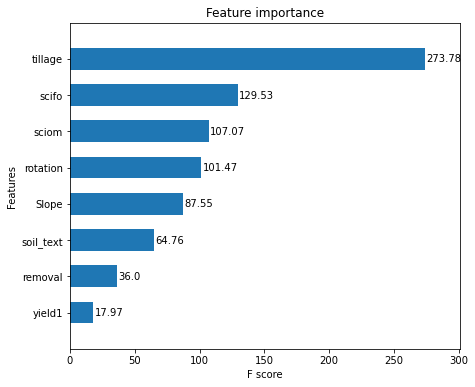

In [70]:
booster = gbm.get_booster()
importance = booster.get_score(importance_type="gain")

for key in importance.keys():
    importance[key] = round(importance[key],2)

fig, ax = plt.subplots(figsize=(7,6))
ax = plot_importance(importance, max_num_features=8, importance_type='gain',height = 0.6,  show_values=True, ax=ax, grid = False)


In [72]:
grad_boost = GradientBoostingClassifier()
grad_boost.fit(X_train_scaled, y_train)
print(grad_boost.score(X_train_scaled,y_train))
print(grad_boost.score(X_test_scaled,y_test))

0.9033753756839374
0.8996455130428082


In [73]:
prediction = grad_boost.predict(X_test_scaled)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83     16404
           1       0.91      0.95      0.93     35502

    accuracy                           0.90     51906
   macro avg       0.89      0.87      0.88     51906
weighted avg       0.90      0.90      0.90     51906



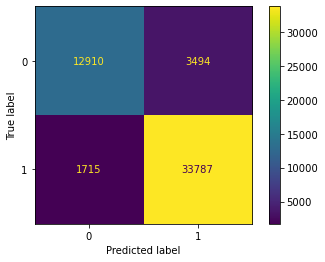

In [74]:
plot_confusion_matrix(grad_boost, X_test_scaled, y_test)

0.8707904133165506
0.870130620737487
              precision    recall  f1-score   support

           0       0.82      0.75      0.79     16404
           1       0.89      0.92      0.91     35502

    accuracy                           0.87     51906
   macro avg       0.86      0.84      0.85     51906
weighted avg       0.87      0.87      0.87     51906



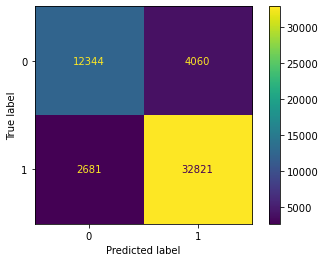

In [75]:
ada = AdaBoostClassifier()
ada.fit(X_train_scaled, y_train)
print(ada.score(X_train_scaled, y_train))
print(ada.score(X_test_scaled,y_test))
prediction = ada.predict(X_test_scaled)
print(classification_report(y_test, prediction))
plot_confusion_matrix(ada, X_test_scaled, y_test)

A summary of classifiers that would work well for this dataset.

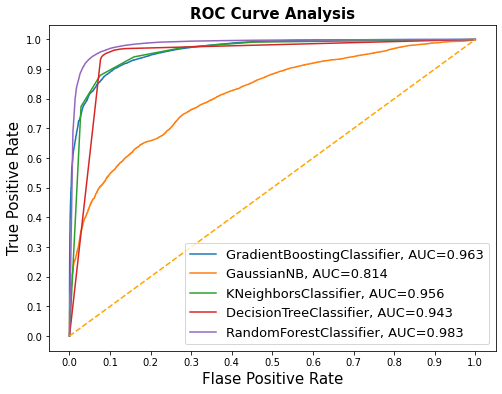

In [80]:
#Code from https://abdalimran.github.io/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot

classifiers = [GradientBoostingClassifier(), 
               GaussianNB(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(random_state=1234),
               RandomForestClassifier(random_state=1234)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

_____

Below is code to create a smaller dataframe that would import into Stremlit.

In [86]:
small_df = df[['soil_erosion', 'Slope','scifo','sciom','rotation', 'soil_text','yield1']]
small_df = small_df.dropna()

#Set threshold and classify the target value into tolerated or not tolerated.
def func(y):
    if y <= 5: #Values for erosion that are above the NRCS tolerable soil loss limit of 1.12 kg m-2 (5 tons acre-1 ). 58(2):
        return 'tolerated'
    else:
        return 'not tolerated'
small_df['soil_erosion'] = small_df['soil_erosion'].apply(func)

le = LabelEncoder()
small_df2 = small_df.copy()
small_df2.loc[:,'rotation'] = le.fit_transform(small_df2['rotation'])
small_df2.loc[:,'soil_text'] = le.fit_transform(small_df2['soil_text'])
small_df2['soil_erosion'] = le.fit_transform(small_df2['soil_erosion'])
small_df2.columns


Index(['soil_erosion', 'Slope', 'scifo', 'sciom', 'rotation', 'soil_text',
       'yield1'],
      dtype='object')

In [90]:
small_df2.to_csv('df_streamlit.csv')